In [ ]:
import pandas as pd
import string
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import model_selection, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale,StandardScaler,MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold

from warnings import filterwarnings
filterwarnings("ignore")

import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
import nltk.corpus
from nltk.corpus import stopwords
import re

!pip install emoji
!pip install ekphrasis -U
!pip install vaderSentiment
!pip install textstat

import emoji

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

#### Load & pre-process

In [3]:
# LOAD TEXT PREPROCESSOR

# text pre-processor

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    dicts=[emoticons]
)

# text pre-processing function

def preprocess(text, processor, demojize=False):
  if demojize:
    text = re.sub("_"," ", emoji.replace_emoji(text, replace=lambda chars, data_dict: data_dict['en'].replace(':',' ')))
  text = " ".join(text_processor.pre_process_doc(text))
  text = text.replace('<allcaps> url </allcaps>', '<url>')
  return text

# nltk.TweetTokenizer
tweet_tokenizer = TweetTokenizer(strip_handles=False)


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


In [3]:
# DEMO: TEXT PREPROCESSOR

tweet1 = "@USER @USER Go home you're drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL"
tweet2 = '@USER @USER Oh noes! Tough shit.'
tweet3 = '@USER You are amazing 💛💛💛'
tweet4 = '@USER you are a lying corrupt traitor!!! Nobody wants to hear anymore of your lies!!! #DeepStateCorruption URL'
tweet5 = '@USER She should ask a few native Americans what their take on this is.'
tweet6 = "#cancelsouthpark They were liberals when you were still suckin' on your momma's titty at the other woodstock."
demo_tweets = [tweet1, tweet2, tweet3, tweet4, tweet5, tweet6]

# ekphrasis text preprocessor demo
print('DEMO: TEXT PROCESSOR')
for tweet in demo_tweets:
    print(preprocess(tweet, text_processor, demojize=False))

print('\nDEMO: TEXT PROCESSOR + DEMOJIZE')
for tweet in demo_tweets:
    print(preprocess(tweet, text_processor, demojize=True))

print('\nDEMO: nltk.TweetTokenizer')
for tweet in demo_tweets:
    print(tweet_tokenizer.tokenize(tweet))

print('\nDEMO: remove emojis')
for tweet in demo_tweets:
    print(tweet.encode('ascii','ignore').decode('ascii'))

DEMO: TEXT PROCESSOR
<user> <user> go home you are drunk ! <repeated> <user> <hashtag> maga </hashtag> <hashtag> trump 2020 </hashtag> 👊 🇺 🇸 👊 <url>
<user> <user> oh noes ! tough shit .
<user> you are amazing 💛 💛 💛
<user> you are a lying corrupt traitor ! <repeated> nobody wants to hear anymore of your lies ! <repeated> <hashtag> deep state corruption </hashtag> <url>
<user> she should ask a few native americans what their take on this is .
<hashtag> cancel south park </hashtag> they were liberals when you were still suckin ' on your momma ' s titty at the other woodstock .

DEMO: TEXT PROCESSOR + DEMOJIZE
<user> <user> go home you are drunk ! <repeated> <user> <hashtag> maga </hashtag> <hashtag> trump 2020 </hashtag> oncoming fist united states oncoming fist <url>
<user> <user> oh noes ! tough shit .
<user> you are amazing yellow heart yellow heart yellow heart
<user> you are a lying corrupt traitor ! <repeated> nobody wants to hear anymore of your lies ! <repeated> <hashtag> deep sta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
# LOAD DATASET

train_data=pd.read_csv('/content/drive/My Drive/OLID/olid-training-v1.0.tsv', delimiter='\t', encoding='utf-8')
#train_tweets = train_data[['tweet']]

df = train_data[['tweet','subtask_a']]
df.head()

# normalize punctuation
df['tweet'] = df.tweet.str.replace('’',"'")
df['tweet'] = df.tweet.str.replace('“','"')
df['tweet'] = df.tweet.str.replace('”','"')
df['tweet'] = df.tweet.str.replace('&lt;','')
df['tweet'] = df.tweet.str.replace('&gt;','')
df['tweet'] = df.tweet.str.replace('&amp;','and')

# pre-process
df['clean'] = [clean(tweet) for tweet in df['tweet']]

processed = [preprocess(tweet, text_processor, demojize=False) for tweet in df['tweet']] 
processed_demojized = [preprocess(tweet, text_processor, demojize=True) for tweet in df['tweet']]

df['processed'] = processed
df['processed_demojized'] = processed_demojized 

# check
for t, t_p, t_dp in zip(df['tweet'][:5], df['processed'][:5], df['processed_demojized'][:5]):
  print(t)
  print(t_p)
  print(t_dp)
  print()

@USER She should ask a few native Americans what their take on this is.
<user> she should ask a few native americans what their take on this is .
<user> she should ask a few native americans what their take on this is .

@USER @USER Go home you're drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL
<user> <user> go home you are drunk ! <repeated> <user> <hashtag> maga </hashtag> <hashtag> trump 2020 </hashtag> 👊 🇺 🇸 👊 <url>
<user> <user> go home you are drunk ! <repeated> <user> <hashtag> maga </hashtag> <hashtag> trump 2020 </hashtag> oncoming fist united states oncoming fist <url>

Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT
amazon is investigating chinese employees who are selling internal data to third - party sellers looking for an edge in the competitive marketplace . <url> <hashtag> amazon </hashtag> <hashtag> maga </hashtag> <hashtag> kag </hashtag> <h

In [8]:
# functions for cleaning/stemming

def clean(tweet):
    tweet = tweet.replace('@USER', '')
    tweet = tweet.replace('URL', '')
    tweet = tweet.replace('\d+','')
    tweet = tweet.lower()

    # remove punctuation
    for punctuation in string.punctuation:
       tweet = tweet.replace(punctuation, '')

    # remove emojis
    tweet = tweet.encode('ascii','ignore').decode('ascii')

    return tweet.strip()

def remove_special(text):
    # remove punctuations and special tags <>
    text = re.sub("<[^>]+>","", text)
    tknzr = TweetTokenizer(strip_handles=True)
    tokens = tknzr.tokenize(text)
    clean_tweet = ''
    for t in tokens:
      if t not in string.punctuation:
        clean_tweet = clean_tweet + ' ' + t
    return clean_tweet.strip()

def stem_new(text, remove_stopwords=False):
    text = re.sub("<[^>]+>","", text)
    text = text.encode('ascii','ignore').decode('ascii') # remove emojis
    tknzr = TweetTokenizer(strip_handles=True)
    tokens = tknzr.tokenize(text)

    stemmer = PorterStemmer()
    stems = ''

    for t in tokens:
        if t not in string.punctuation:
          if remove_stopwords:
            if t not in stopwords.words('english'):
              s = stemmer.stem(t)
              stems = stems + ' ' + s
          else:
            s = stemmer.stem(t)
            stems = stems + ' ' + s

    return stems.strip()


In [9]:
# tweets without punctuation and special tags <>, with emojis mapped to words
df['words_demojized'] = [remove_special(tweet) for tweet in df['processed_demojized']]

# stems

# stems (no punctuation, no special tags <>, no stopwords, no emojis)
df['stems'] = [stem_new(tweet, remove_stopwords=True) for tweet in df['processed']]
# stems (no punctuation, no special tags <>, no stopwords, with emojis mapped to words)
df['stems_demojized'] = [stem_new(tweet, remove_stopwords=True) for tweet in df['processed_demojized']]

In [14]:
df.head()

,tweet,subtask_a,clean,processed,processed_demojized,words_demojized,stems,stems_demojized
0,@USER She should ask a few native Americans wh...,OFF,she should ask a few native americans what the...,<user> she should ask a few native americans w...,<user> she should ask a few native americans w...,she should ask a few native americans what the...,ask nativ american take,ask nativ american take
1,@USER @USER Go home you're drunk!!! @USER #MAG...,OFF,go home youre drunk maga trump2020,<user> <user> go home you are drunk ! <repeate...,<user> <user> go home you are drunk ! <repeate...,go home you are drunk maga trump 2020 oncoming...,go home drunk maga trump 2020,go home drunk maga trump 2020 oncom fist unit ...
2,Amazon is investigating Chinese employees who ...,NOT,amazon is investigating chinese employees who ...,amazon is investigating chinese employees who ...,amazon is investigating chinese employees who ...,amazon is investigating chinese employees who ...,amazon investig chines employe sell intern dat...,amazon investig chines employe sell intern dat...
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,someone shouldvetaken this piece of shit to a ...,"<user> someone should havetaken "" this piece o...","<user> someone should havetaken "" this piece o...",someone should havetaken this piece of shit to...,someon havetaken piec shit volcano,someon havetaken piec shit volcano face tear joy
4,@USER @USER Obama wanted liberals and illegals...,NOT,obama wanted liberals and illegals to move int...,<user> <user> obama wanted liberals and illega...,<user> <user> obama wanted liberals and illega...,obama wanted liberals and illegals to move int...,obama want liber illeg move red state,obama want liber illeg move red state


subtask_a
NOT    8840
OFF    4400
Name: subtask_a, dtype: int64


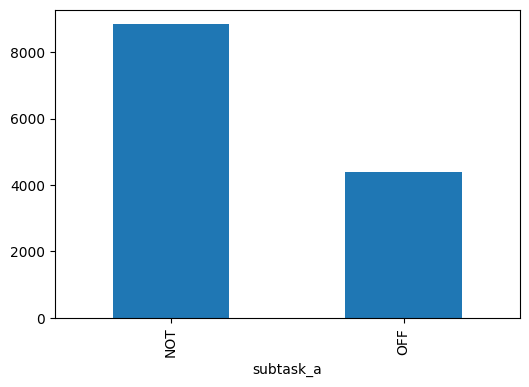

In [66]:
# NOT / OFF count

def plot_classes(df, column_name):
    plt.figure(figsize=(6,4))
    print(df.groupby(column_name)[column_name].count())
    df.groupby(column_name)[column_name].count().plot.bar(ylim=0)
    plt.show()

plot_classes(df,"subtask_a")

In [67]:
# most common non-stopword stems in offensive/not offensive tweets

df_off = df[df.subtask_a =="OFF"]
df_not = df[df.subtask_a =="NOT"] 

off_count = Counter(" ".join(df_off['stems']).split())
print('OFF', off_count.most_common(10))

not_count = Counter(" ".join(df_not['stems']).split())
print('NOT', not_count.most_common(10))

OFF [('liber', 664), ('gun', 577), ('like', 509), ('control', 468), ('peopl', 391), ('shit', 338), ('get', 338), ('fuck', 334), ('antifa', 330), ('go', 314)]
NOT [('liber', 1032), ('gun', 992), ('antifa', 877), ('control', 805), ('conserv', 791), ('maga', 746), ('like', 701), ('get', 573), ('peopl', 572), ('trump', 507)]


In [ ]:
#print(np.unique(re.findall('<[^>]+>', " ".join(df['processed']))))

#### Feature extraction

In [12]:
# LOAD SENTIMENT ANALYZER

sentiment_analyzer = VS()

In [ ]:
# DEMO: SENTIMENT ANALYZER

tweet1 = "@USER @USER Go home you're drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL"
tweet2 = '@USER @USER Oh noes! Tough shit.'
tweet3 = '@USER You are amazing 💛💛💛'
tweet4 = '@USER you are a lying corrupt traitor!!! Nobody wants to hear anymore of your lies!!! #DeepStateCorruption URL'
tweet5 = '@USER She should ask a few native Americans what their take on this is.'
tweet6 = "#cancelsouthpark They were liberals when you were still suckin' on your momma's titty at the other woodstock."
demo_tweets = [tweet1, tweet2, tweet3, tweet4, tweet5, tweet6]

# sentiment analyzer

print('DEMO: SENTIMENT ANALYZER')
print('neg', '\t', 'pos', '\t', 'neu', '\t', 'compound')

for tweet in demo_tweets:
  sentiment = sentiment_analyzer.polarity_scores(tweet)
  print(sentiment['neg'], '\t', sentiment['pos'], '\t', sentiment['neu'], '\t', sentiment['compound'])

DEMO: SENTIMENT ANALYZER
neg 	 pos 	 neu 	 compound
0.201 	 0.0 	 0.799 	 -0.5067
0.574 	 0.0 	 0.426 	 -0.6588
0.0 	 0.732 	 0.268 	 0.9545
0.329 	 0.0 	 0.671 	 -0.811
0.0 	 0.0 	 1.0 	 0.0
0.0 	 0.0 	 1.0 	 0.0


In [13]:
# FEATURE EXTRACTION FUNCTIONS (sentiment, readability scores, count of <user>/<hashtag>/...)

# get sentiment scores

names_sent = ["vader neg","vader pos","vader neu", "vader compound"]

def get_sent(tweet, sentiment_analyzer):
  sentiment = sentiment_analyzer.polarity_scores(tweet)  
  return [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']]


# count objects <>

names_obj = ["num_hashtags", "num_mentions", "num_urls", 
              "num_repeated","num_elongated", "num_censored", "num_allcaps","num_emphasis",
              "num_time","num_date","num_number","num_percent","num_money"]

def find_objs(tweet, obj):
  #print('find_objs', tweet)
  return re.findall(obj, tweet)  

def count_objs(tweet):  
    counts = {
        'url': len(find_objs(tweet, '<url>')),
        'user': len(find_objs(tweet, '<user>')),
        'hashtag': len(find_objs(tweet, '<hashtag>')),
        'repeated': len(find_objs(tweet, '<repeated>')),
        'elongated': len(find_objs(tweet, '<elongated>')),
        'censored': len(find_objs(tweet, '<censored>')),
        'allcaps': len(find_objs(tweet, '<allcaps>')),
        'emphasis': len(find_objs(tweet, '<emphasis>')),
        'time': len(find_objs(tweet, '<time>')),
        'date': len(find_objs(tweet, '<date>')),
        'number': len(find_objs(tweet, '<number>')),
        'percent': len(find_objs(tweet, '<percent>')),
        'money': len(find_objs(tweet, '<money>')),
    }
    return counts

def get_obj_counts(tweet):
  twitter_objs = count_objs(tweet)
  return [
      twitter_objs['hashtag'], twitter_objs['user'], twitter_objs['url'],
      twitter_objs["repeated"],twitter_objs["elongated"],twitter_objs["censored"],twitter_objs["allcaps"],twitter_objs["emphasis"],
      twitter_objs["time"],twitter_objs["date"],twitter_objs["number"],twitter_objs["percent"],twitter_objs["money"]
        ]

# other features

names_other = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "num_punct"]

def get_other(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
   
    words = tweet
    
    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    # Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)

    # Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    punct = set(string.punctuation)
    punct.remove('#')
    num_punct = len([c for c in tweet if c in punct])
    
    features = [FKRA, FRE, syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, num_punct
                ]
    return features


names_all = names_other + names_sent + names_obj

def get_feature_array(df, extract_features=['other','sent','obj']):
    # get features for all tweets
    feats_all = []
    feats_sent = []
    feats_obj = []
    feats_other = []
    if 'other' in extract_features:
      for t in df['tweet']:
        feats_other.append(get_other(t))
      feats_all.append(feats_other)
    if 'sent' in extract_features:
      for t in df['tweet']:
        feats_sent.append(get_sent(t, sentiment_analyzer))
      feats_all.append(feats_sent)
    if 'obj' in extract_features:
      for t in df['processed']:
          feats_obj.append(get_obj_counts(t))
      feats_all.append(feats_obj)
    return np.concatenate(feats_all, axis=1)


In [48]:
# DEMO: OTHER FEATURES

print(df['tweet'][0])
print(df['tweet'][1])
print()
print('OTHER:',get_other(df['tweet'][0]))
print('OTHER:',get_other(df['tweet'][1]))
print()
print('OBJ COUNTS:',get_obj_counts(df['processed'][0]))
print('OBJ COUNTS:',get_obj_counts(df['processed'][1]))
print()
print('SENTIMENT:',get_sent(df['tweet'][0], sentiment_analyzer))
print('SENTIMENT:',get_sent(df['tweet'][1], sentiment_analyzer))
print()
print(get_feature_array(df[['tweet','processed']][0:2]))

@USER She should ask a few native Americans what their take on this is.
@USER @USER Go home you're drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL

OTHER: [5.0, 83.85, 18, 1.2857, 71, 71, 14, 14, 14, 2]
OTHER: [3.7, 88.0, 14, 1.2727, 67, 67, 11, 11, 9, 7]

OBJ COUNTS: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
OBJ COUNTS: [2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

SENTIMENT: [0.0, 0.0, 1.0, 0.0]
SENTIMENT: [0.201, 0.0, 0.799, -0.5067]

[[ 5.     83.85   18.      1.2857 71.     71.     14.     14.     14.
   2.      0.      0.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 3.7    88.     14.      1.2727 67.     67.     11.     11.      9.
   7.      0.201   0.      0.799  -0.5067  2.      3.      1.      1.
   0.      0.      0.      0.      0.      0.      0.      0.      0.    ]]


In [32]:
# EXTRACT FEATURES

extracted_other_obj_sent = get_feature_array(df[['tweet','processed']])

extracted_other = get_feature_array(df[['tweet','processed']], extract_features=['other'])
extracted_sent = get_feature_array(df[['tweet','processed']], extract_features=['sent'])
extracted_obj = get_feature_array(df[['tweet','processed']], extract_features=['obj'])

print(extracted_other.shape, extracted_sent.shape, extracted_obj.shape)

(13240, 10) (13240, 4) (13240, 13)


In [17]:
# ENCODE LABELS

encoder = LabelEncoder()
y = encoder.fit_transform(df['subtask_a'])

name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print('labels:', name_mapping)


labels: {'NOT': 0, 'OFF': 1}


#### Validation

In [15]:
skf = StratifiedKFold(n_splits=6)


# functions to calculate avg results

def get_results(classification_reports):
  # calculate mean from list of classification reports
  results = dict()
  results['accuracy'] = np.mean([report['accuracy'] for report in classification_reports])
  for r in ['0','1','macro avg','weighted avg']:
    results[r] = dict()
    for metric in ['precision','recall','f1-score']:
      results[r][metric] = np.mean([report[r][metric] for report in classification_reports])
  return results

def print_results(results):
  print('{:15s}'.format('accuracy'), results['accuracy'])
  for r in ['0','1','macro avg','weighted avg']:
    print('{:15s}'.format(r), end=' ')
    for metric, name in zip(['precision','recall','f1-score'],['P:','R:','F1:']):
      print(name, results[r][metric])


# function for cross validation

def cross_validate(vectorizer, tfidf_column, model, extract_features=['other','sent','obj'], verbose=False):

  classification_reports = []

  iter = 0
  for indices_train, indices_val in skf.split(df, y):
    if iter == 1:
      break
    iter += 1

    if verbose:
      print('(NOT, OFF) | train: {} | test: {}'.format(tuple(np.bincount(y[indices_train])), tuple(np.bincount(y[indices_val]))), end=' ')

    df_train, y_train = df.loc[df.index[indices_train]], y[indices_train]
    df_val, y_val = df.loc[df.index[indices_val]], y[indices_val]

    tfidf_train = vectorizer.fit_transform(df_train[tfidf_column]).toarray()
    tfidf_val = vectorizer.transform(df_val[tfidf_column]).toarray()

    X_train = pd.DataFrame(np.concatenate([tfidf_train],axis=1)) #, extracted_other[indices_train], extracted_sent[indices_train], extracted_obj[indices_train]
    X_val = pd.DataFrame(np.concatenate([tfidf_val],axis=1)) #, extracted_other[indices_val], extracted_sent[indices_val], extracted_obj[indices_val]

    model = model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True)
    classification_reports.append(report)

    if verbose:
      print('| macro avg f1-score: {:.6f}'.format(report['macro avg']['f1-score']))
  return classification_reports[0]
  #return get_results(classification_reports)


In [15]:
options_tfidf_column = ['clean','stems','stems_demojized',]

options_vectorizer = list(itertools.product([(1,2),(1,3)],[None,1000]))

options_model = [1e-1,1,1e1]

In [ ]:
#best_f1 = [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
#best_configs = {0:None,1:None,2:None,3:None,4:None,5:None,6:None,7:None,8:None,9:None}

br = 0
for C in options_model:
  print(C)
  for nrange in [(1,2)]:
    print(nrange)
    for tfidf_column in ['stems']: #'clean','stems','stems_demojized'
      print(tfidf_column, end=' ')
      model = svm.SVC(kernel='linear', random_state=5, C=C, class_weight='balanced')
      #for ngram_range,max_features in options_vectorizer:
      if tfidf_column == 'clean':
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5,norm='l2',ngram_range=nrange, stop_words='english') # , stop_words='english'
      else:
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5,norm='l2',ngram_range=nrange)
      report = cross_validate(vectorizer, tfidf_column, model, verbose=False)
      f1 = report['macro avg']['f1-score']
      print(f1)

      #min_f1_index = np.argmin(best_f1)
      #if f1 > best_f1[min_f1_index]:
      #  best_f1[min_f1_index] = f1
      #  #best_configs[min_f1_index] = (C, ngram_range,max_features, tfidf_column) 

      #print(best_f1)
      #print(best_configs) 
      #print()

#### Test

In [54]:
# VECTORIZER & MODEL

tfidf_column = 'stems'
test_stop_words = None

minmax_scaler = MinMaxScaler()

test_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5,norm='l2',ngram_range=(1, 2), stop_words=test_stop_words)


In [55]:
# TRAIN + VAL

extracted_other_obj_sent_scaled = minmax_scaler.fit_transform(extracted_other_obj_sent)

tfidf_df = test_vectorizer.fit_transform(df[tfidf_column]).toarray()

X_df = pd.DataFrame(np.concatenate([tfidf_df, extracted_other_obj_sent_scaled],axis=1))


In [ ]:
print(tfidf_df.shape)
print(X_df.shape)

In [39]:
# TEST SET: LOAD, PREPROCESS

test_tweet_a=pd.read_csv('/content/drive/My Drive/OLID/testset-levela.tsv', delimiter='\t', encoding='utf-8')
test_label_a = pd.read_csv('/content/drive/My Drive/OLID/labels-levela.csv', delimiter=',', encoding='utf-8', index_col=False, header=None, names=['id','subtask_a'])
test_data = test_tweet_a.merge(test_label_a, on='id')
test_data = test_data.drop(columns='id')

df_test = test_data[['tweet','subtask_a']]

# normalize punctuation
df_test['tweet'] = df_test.tweet.str.replace('’',"'")
df_test['tweet'] = df_test.tweet.str.replace('“','"')
df_test['tweet'] = df_test.tweet.str.replace('”','"')
df_test['tweet'] = df_test.tweet.str.replace('&lt;','')
df_test['tweet'] = df_test.tweet.str.replace('&gt;','')
df_test['tweet'] = df_test.tweet.str.replace('&amp;','and')

# pre-process
df_test['clean'] = [clean(tweet) for tweet in df_test['tweet']]
df_test['processed'] = [preprocess(tweet, text_processor, demojize=False) for tweet in df_test['tweet']] 
df_test['processed_demojized'] = [preprocess(tweet, text_processor, demojize=True) for tweet in df_test['tweet']] 
df_test['words_demojized'] = [remove_special(tweet) for tweet in df_test['processed_demojized']]
df_test['stems'] = [stem_new(tweet, remove_stopwords=True) for tweet in df_test['processed']]
df_test['stems_demojized'] = [stem_new(tweet, remove_stopwords=True) for tweet in df_test['processed_demojized']]

In [ ]:
# TEST SET: EXTRACT FEATURES

test_extracted_other_obj_sent = get_feature_array(df_test[['tweet','processed']])
test_extracted_other_obj_sent_scaled = minmax_scaler.transform(test_extracted_other_obj_sent)

tfidf_test = test_vectorizer.transform(df_test[tfidf_column]).toarray()

X_test = np.concatenate([tfidf_test, test_extracted_other_obj_sent_scaled],axis=1) 
print(X_test.shape)
X_test = pd.DataFrame(X_test)

y_test = encoder.transform(df_test['subtask_a'])

In [ ]:
# svm.SVC classifier

model_svc = svm.SVC(kernel="linear", random_state=5, class_weight='balanced')
model_svc = model_svc.fit(X_df,y)
pickle.dump(model_svc, open('model_stems_sent.sav', 'wb'))
y_preds_test = model_svc.predict(X_test)
print(classification_report(y_test, y_preds_test))
report_test = classification_report(y_test, y_preds_test, output_dict=True)

pickle.dump(y_preds_test, open('model_stems_sent.sav', 'wb'))
pickle.dump(report_test, open('model_stems_sent.sav', 'wb'))

In [59]:
with open('model_stems_other_preds.sav', 'rb') as f:
    data = pickle.load(f)
    print(classification_report(y_test, data))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       620
           1       0.62      0.67      0.65       240

    accuracy                           0.79       860
   macro avg       0.75      0.76      0.75       860
weighted avg       0.80      0.79      0.80       860



In [68]:
with open('model_stems_preds.sav', 'rb') as f:
    data = pickle.load(f)
    print(classification_report(y_test, data))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       620
           1       0.60      0.65      0.62       240

    accuracy                           0.78       860
   macro avg       0.73      0.74      0.73       860
weighted avg       0.79      0.78      0.78       860



In [45]:
def plot_conf_matrix(test_label, predicted_label):
    cm = confusion_matrix(test_label, predicted_label)
    class_names=['NOT','OFF'] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))

    h = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g',annot_kws={"size": 20},xticklabels=class_names, yticklabels=class_names)
    ax.xaxis.set_label_position("top")
    h.set_xticklabels(h.get_xticklabels(), size = 20)
    h.set_yticklabels(h.get_yticklabels(), size = 20)


    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20);

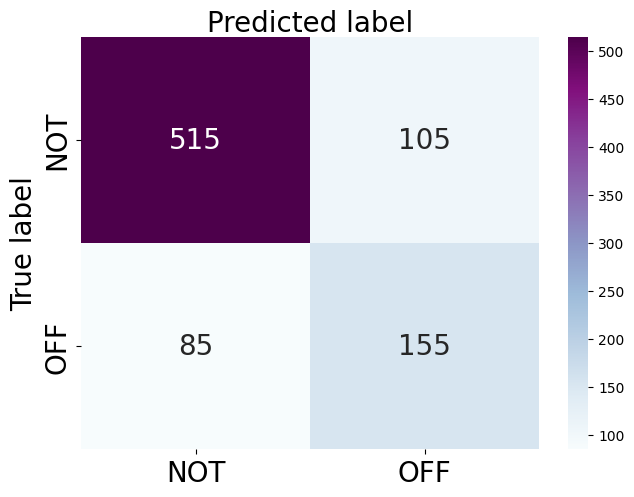

In [46]:
with open('model_stems_preds.sav', 'rb') as f:
    data = pickle.load(f)
    plot_conf_matrix(y_test,data)

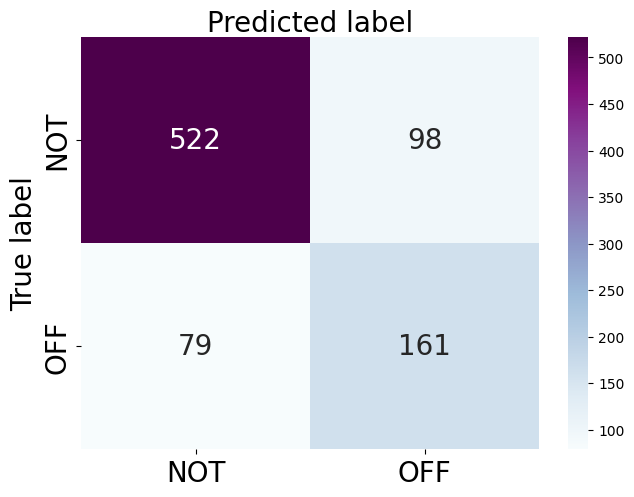

In [47]:
with open('model_stems_other_preds.sav', 'rb') as f:
    data = pickle.load(f)
    plot_conf_matrix(y_test,data)